# Introducción a OpenCV
En esta práctica veremos algunos usos prácticos de OpenCV, centrándonos en el procesamiento de imágenes.

## Líneas de seguimiento

Como ejemplo, extraeremos la línea (hecha de cinta negra adhesiva) del suelo. Extraer la línea del suelo es un problema clásico en la robótica móvil, ya que es una de las referencias más importantes para la navegación.

In [12]:
# Instalamos las librerías necesarias

%pip install matplotlib opencv-python-headless

In [13]:
# Cargamos las librerías necesarias para la práctica

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Cargando fotos

Cuando cargamos imágenes en OpenCV, se suele usar generalmente una representación como matrices de Numpy; Una dimensión por color.

De esta manera, una imagen en b/n de `542x959` se almacenará en un array de `542x959` y si está en color en una matriz `542x959x3`.


(542, 959, 3)


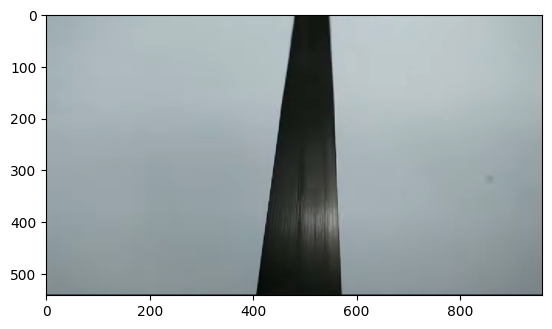

In [14]:
# Cargamos la imagen inicial:

im = cv2.imread("1.-line.png")
print(im.shape)
plt.imshow(im)

Para planificar el siguiente paso, el robot solo necesita la información en la parte inferior de la imagen. Por esta razón, la imagen se puede cortar solo para que se procese la parte inferior.

Dado que la imagen tiene la forma de una matriz, se puede usar la notación de `slicing` de `NumPy` para cortar la imagen. Esto se hace con notación `img[y1:y2, x1:x2]` donde `y1` i `y2` son las coordenadas verticales y `x1` y `x2` las horizontales.

La imagen original tiene un tamaño de `542x959` y queremos cortar la parte inferior de la imagen, por lo que queremos dejar la parte de la imagen que va de la fila `200` hasta el `542` i des de la Columna `0` hasta la `959`.

(342, 959, 3)


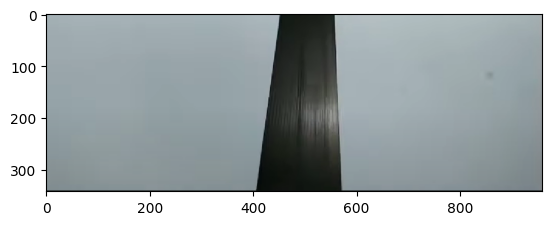

In [15]:
im_baix = im[200:959, 0:959]
print(im_baix.shape)
plt.imshow(im_baix)

### Procesamos la imagen
Para realizar un seguimiento de la línea del suelo, primero debemos convertir la imagen en escala de grises.Podemos hacer esto con la función `cv2.cvtColor`.

(342, 959)


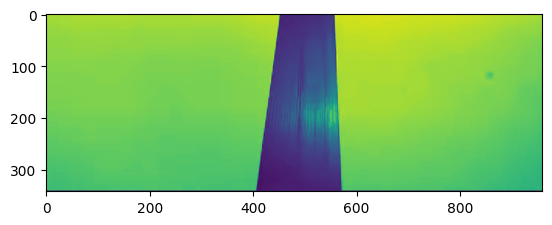

In [16]:
im_bn = cv2.cvtColor(im_baix, cv2.COLOR_BGR2GRAY)
print(im_bn.shape)
plt.imshow(im_bn)

La imagen de la escala de grises es una imagen en la que cada píxel tiene un valor entre 0 y 255, donde 0 es negro y 255 es blanco. Esto nos permite trabajar con una sola dimensión y simplificar el procesamiento de la imagen.

Se muestra en colores para ver mejor, pero el procesamiento se realizará en escala de grises.

Aplicaremos un Gaussianblur para suavizar la imagen y eliminar el ruido. Podemos hacer esto con la función `cv2.GaussianBlur`.

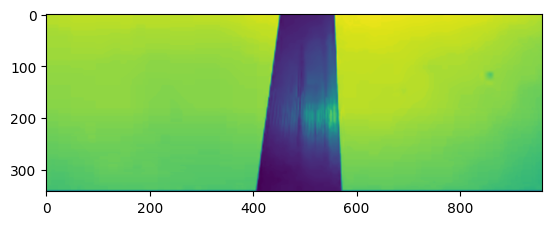

In [17]:
im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
plt.imshow(im_blurred)

### Thresolding

A continuación, haremos _thresolding_ (separar el fondo del primer plano).En este [article](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) podemos ver el procedimiento bien descrito.

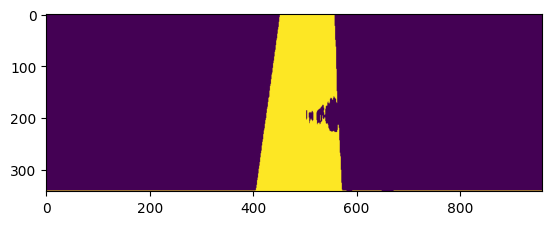

In [18]:
ret, im_th = cv2.threshold(im_blurred,100,255,cv2.THRESH_BINARY_INV)
plt.imshow(im_th)

El método más simple es el _Simple Thresholding_ que simplemente compara cada píxel con un valor y lo convierte en blanco o negro dependiendo de si es más grande o más pequeño. Este método es el más simple y más rápido. Este método se puede usar cuando la imagen está bien iluminada y el fondo es fácil de separar del primer plano.

En nuestro caso, hemos marcado el valor de _threshold_ a 100, pero se puede ajustar de acuerdo con la imagen.

### Busqueda de bordes

Una vez que tenemos la imagen binarizada, podemos buscar los bordes de la línea. Podemos hacer esto con la función `cv2.findContours`. Esta funcion devuelve una lista de bordes, que son una lista de puntos que componen el borde.

A medida que esta función transforma la imagen, haremos una copia de la imagen binarizada para no perder la imagen original.

In [19]:
im_th_copy = im_th.copy()
contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)

Dado que solo estamos interesados ​​en el borde más grande, verificaremos si hay más de un borde y nos quedaremos con el más grande.

Una vez encontrado el borde, buscaremos el centro del borde. Podemos hacer esto con la función `cv2.moments`. Esta función devuelve un diccionario con los momentos de la imagen, que nos permiten calcular el centro del borde. Específicamente: `cX = M["m10"] / M["m00"]` i `cY = M["m01"] / M["m00"]`.

### Dibujamos el borde

Finalmente, dibujaremos el borde en la imagen original. Podemos hacer esto con la función `cv2.drawContours` y `cv2.circle` para dibujar el centro del borde.

493 183


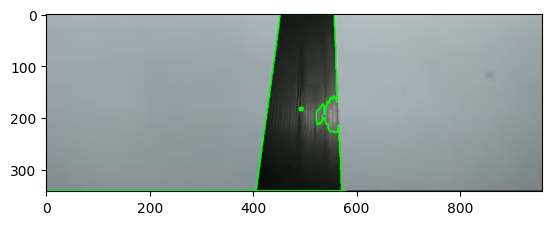

In [20]:
if len(contours) != 0:
    max_contour = max(contours, key = cv2.contourArea)
    center = cv2.moments(max_contour)
    cx = int(center['m10']/center['m00'])
    cy = int(center['m01']/center['m00'])
    print(cx, cy)

    cv2.circle(im_baix, (cx, cy), 5,  (0, 255, 0), -1) #
    cv2.drawContours(im_baix, [max_contour], 0, (0, 255, 0), 2)
    plt.imshow(im_baix)

Finalmente, simulamos el movimiento del robot, causando el centro del borde a la derecha del centro de la imagen
Más de un cierto valor, el borde es rojo, y si está a la izquierda, azul.

También agruparemos todo el código en una función `process_image` que recibirá la imagen como parámetro y devolverá la imagen procesada.

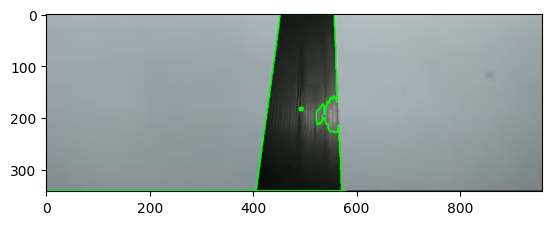

In [21]:
def process_image(im):
    im_baix = im[200:959, 0:959]
    im_bn = cv2.cvtColor(im_baix, cv2.COLOR_BGR2GRAY)
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)
    ret, im_th = cv2.threshold(im_blurred,100,255,cv2.THRESH_BINARY_INV)
    im_th_copy = im_th.copy()
    contours, _ = cv2.findContours(im_th_copy, 1, cv2.CHAIN_APPROX_NONE)
    if len(contours) != 0:
        max_contour = max(contours, key = cv2.contourArea)
        center = cv2.moments(max_contour)
        cx = int(center['m10']/center['m00'])
        cy = int(center['m01']/center['m00'])

        color = (0, 255, 0)

        if cx < 300:
            color = (0, 0, 255)
        elif cx > 600:
            color = (255, 0, 0)

        cv2.circle(im_baix, (cx, cy), 5,  color, -1)
        cv2.drawContours(im_baix, [max_contour], 0, color, 2)

    return im_baix

im = cv2.imread("1.-line.png")
im_proc = process_image(im)
plt.imshow(im_proc)

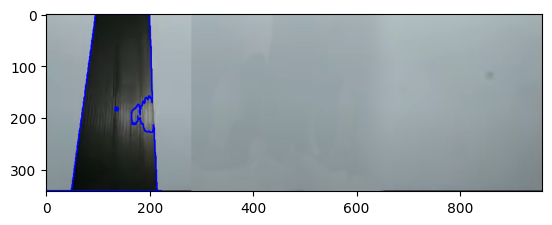

In [22]:
im_left = cv2.imread("1.-line_left.png")
im_proc = process_image(im_left)
plt.imshow(im_proc)

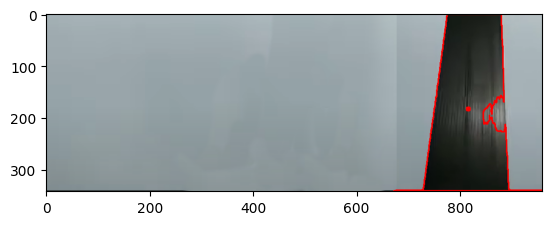

In [23]:
im_right = cv2.imread("1.-line_right.png")
im_proc = process_image(im_right)
plt.imshow(im_proc)

## Detección de movimiento

La detección de movimiento es un problema de visión por computadora muy típico. Nos permitirá, por ejemplo, recibir una alerta cuando alguien entra a nuestra casa.

Las redes neuronales se pueden usar para detectar el movimiento, pero en este caso usaremos un método más simple, basado en la resta de dos imágenes. Si aplicamos redes neuronales cuando sabemos que algo ha sucedido, el costo computacional es mucho más bajo.

La idea a seguir es la siguiente: las imágenes de dos marcos consecutivos son muy similares, pero si hay movimiento, las imágenes serán más diferentes. Como representamos las imágenes como matrices numpy, podemos restar una matriz de la otra y obtener una matriz con las diferencias entre las dos imágenes; será más grande (la diferencia) donde hay movimiento.

Comenzaremos cargando un video y convirtiéndolo en una secuencia de imágenes. Podemos hacer esto con la función `cv2.VideoCapture`.

Loaded 876 frames


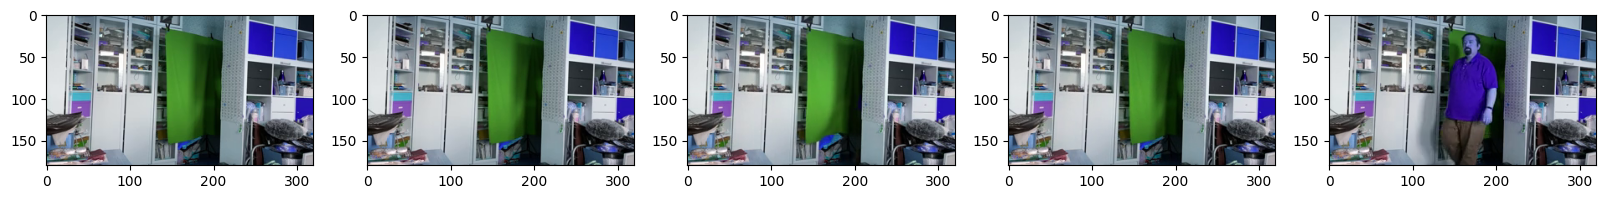

In [24]:
vid = cv2.VideoCapture("1.-motionvideo.mp4")

frames = []
while True:
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)

vid.release()
print(f"Loaded {len(frames)} frames")

# Mostrem els frames de 150 en 150 en una mateixa fila

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(frames[i*150])


El color de la imagen no importa, por lo que lo convertiremos en una escala de grises.

In [25]:
frames_bn = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]

Ahora calcularemos la diferencia entre dos imágenes consecutivas. Podemos hacer esto con la resta de las matrices de Numpy.

In [26]:
diffs = [(p2 - p1) for p1, p2 in zip(frames_bn[:-1], frames_bn[1:])]

La norma de un vector es la longitud (en sentido geométrico) del vector. En nuestro caso, la norma de la resta nos dará un gran valor donde hay movimiento y un pequeño valor donde no hay movimiento, porque el resto será grande donde hay movimiento y pequeño donde no hay.

Calcularemos un vector en las reglas de las diferencias y mostraremos un gráfico con estas reglas, para visualizar dónde hay movimiento.

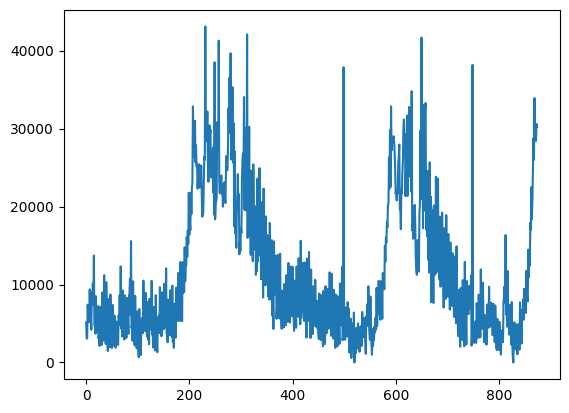

In [27]:
diffs_norms = np.array([np.linalg.norm(x) for x in diffs])

plt.plot(diffs_norms)

Podemos ver que hay algunos cuadros con mucho movimiento, y otros donde no hay movimiento. También podemos mostrar diferencias como una imagen para visualizar qué partes de la imagen son las que se mueven.

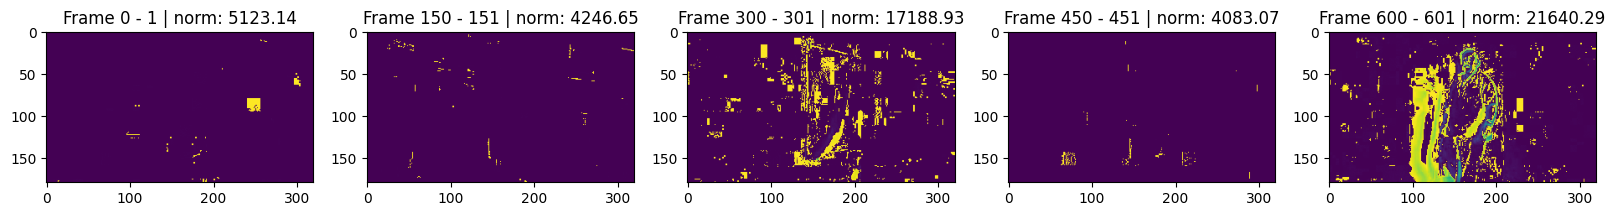

In [28]:
# Mostrem diffs de 150 en 150

fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    axs[i].imshow(diffs[i*150])
    axs[i].set_title(f"Frame {i*150} - {i*150+1} | norm: {diffs_norms[i*150]:.2f}")

Para poder mostrar los frames apropiados de cada _evento de movimiento_, puede ser una buena idea identificar los marcos de inicio y finalización de cada evento de movimiento y mostrar el frame central de cada evento.

Para comenzar, marcaremos un _threshold_ para considerar que hay movimiento y crearemos un vector con los marcos donde hay movimiento

In [29]:
thresold = 15000
frames_moviment = [i for i, frame in enumerate(frames) if diffs_norms[i-1] > thresold]

frames_minims_event = 30

# Haurem de buscar les subsequències de frames_moviment que tinguin com a mínim frames_minims_event frames y no siguen consecutius

def find_events(frames_moviment, frames_minims_event):
    events = []
    event = []
    for i, frame in enumerate(frames_moviment):
        if len(event) == 0:
            event.append(frame)
        else:
            if frame - event[-1] == 1:
                event.append(frame)
            else:
                if len(event) >= frames_minims_event:
                    events.append(event)
                event = []
    return events

events = find_events(frames_moviment, frames_minims_event)
print(events)

[[199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291], [582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639]]


Finalmente mostraremos el marco central de cada evento de movimiento.

Event from frame 199 to frame 291
Event from frame 582 to frame 639


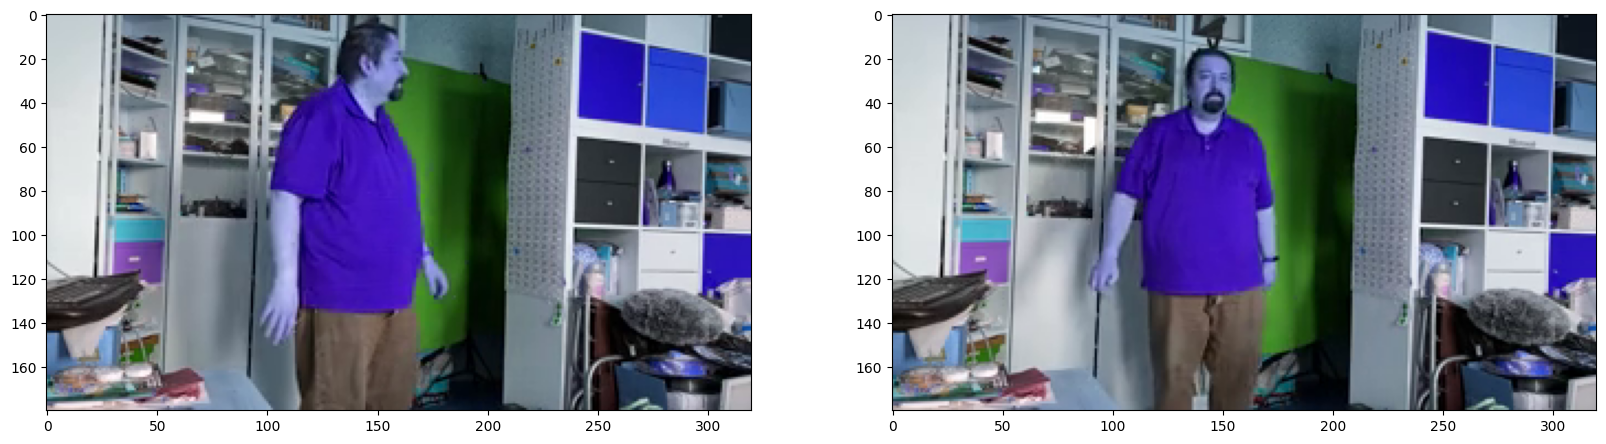

In [30]:
for event in events:
    print(f"Event from frame {event[0]} to frame {event[-1]}")

fig, axs = plt.subplots(1, len(events), figsize=(20, 20))
for i in range(len(events)):
    # Frame central de l'event
    frame = events[i][len(events[i])//2]
    axs[i].imshow(frames[frame])

Podemos ver cómo el color de las imágenes no es el correcto, ya que las personas, por ejemplo, se ven en colores azulados. Esto se debe a que OpenCV carga las imágenes en formato BGR (por cuestiones históricas de compatibilidad) y Matplotlib las muestra en formato RGB. Es por eso que debemos convertir las imágenes en formato RGB antes de mostrarlas. Podemos hacer esto con la función `cv2.cvtcolor`.

Aquí lo haremos antes de mostrar, pero generalmente es una buena idea hacerlo antes de procesar las imágenes.

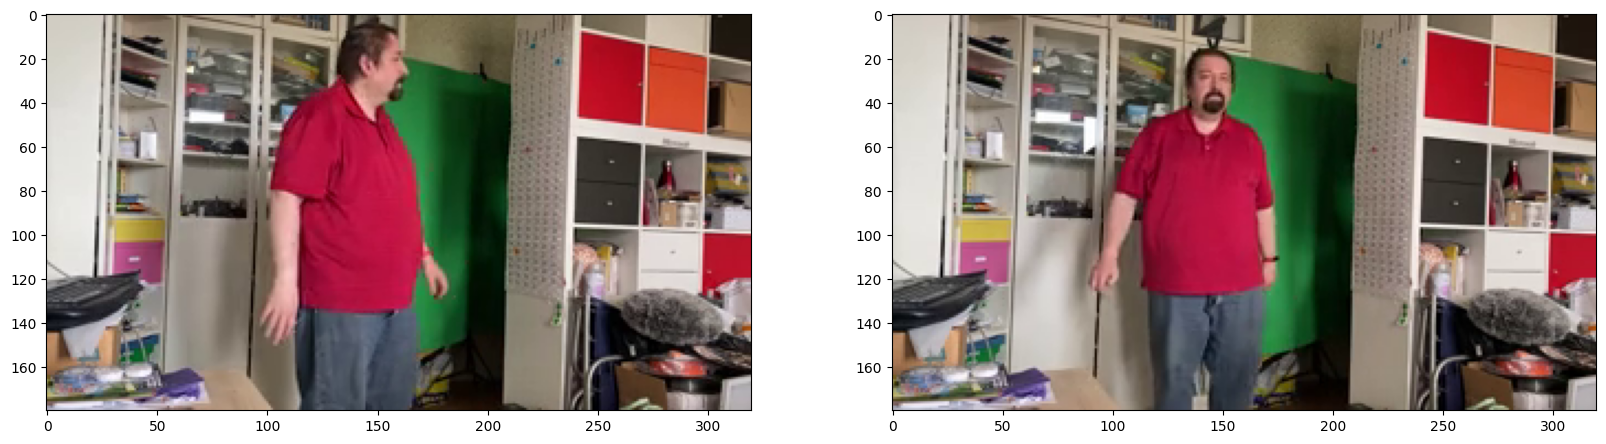

In [31]:
frames_rgb = [cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) for frame in frames]

fig, axs = plt.subplots(1, len(events), figsize=(20, 20))
for i in range(len(events)):
    # Frame central de l'event
    frame = events[i][len(events[i])//2]
    axs[i].imshow(frames_rgb[frame])

## Flujo óptico

El flujo óptico es otro método para detectar el movimiento. Este método calcula el movimiento de cada píxel entre dos cuadros consecutivos. Esto nos permitirá calcular la dirección y la velocidad del movimiento de cada píxel. Es más costoso, pero nos permitirá calcular la dirección y la velocidad del movimiento.

El flujo óptico se puede calcular con la función `cv2.calcOpticalFlowFarneback`. Esta función devuelve una matriz con el movimiento de cada píxel entre dos cuadros consecutivos.

In [32]:
flows = [cv2.calcOpticalFlowFarneback(frames_bn[i], frames_bn[i+1], None, 0.5, 3, 15, 3, 5, 1.2, 0) for i in range(len(frames_bn)-1)]

flows[0].shape

(180, 320, 2)

Cada flujo tiene el tamaño de la imagen y contiene dos valores: el movimiento horizontal y vertical.

Representar el flujo óptico 2D es un poco complicado, pero podemos usar una idea inteligente. Si convertimos el flujo óptico en coordenadas polares, obtendremos dos componentes para cada píxel: dirección e intensidad. Podemos representar la intensidad con la intensidad del píxel y la dirección con diferentes colores. Crearemos una imagen en el espacio de color HSV (valor-saturación de tono), donde el matiz se definirá por la dirección, el valor para la intensidad y la saturación será 255.

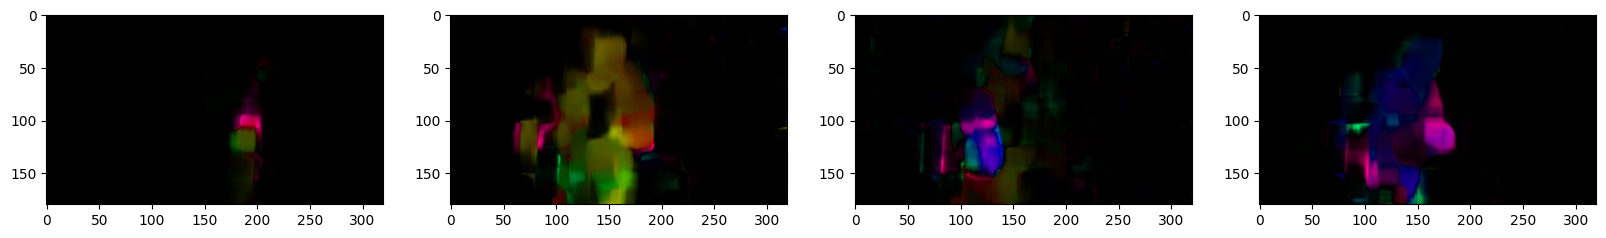

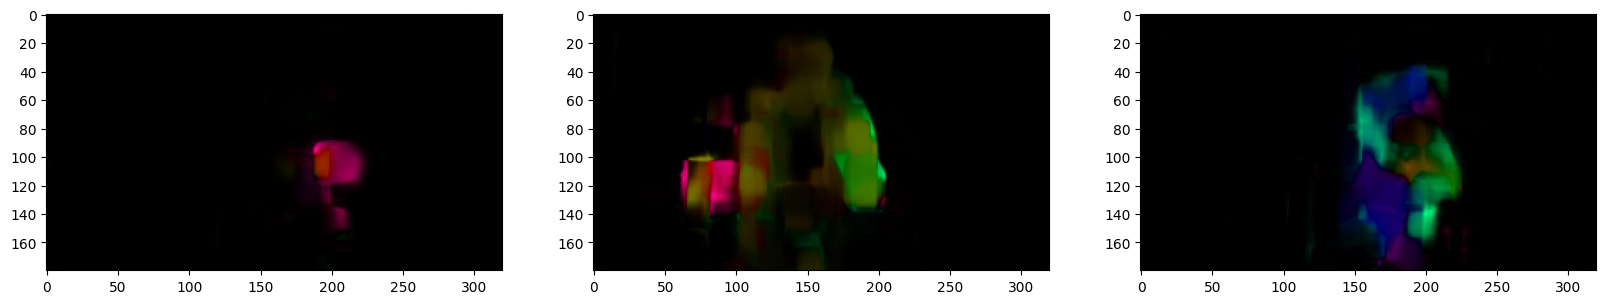

In [33]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)


for event in events:
    start = event[0]
    stop = event[-1]
    frms = [flow_to_hsv(x) for x in flows[start:stop]]

    fig, axs = plt.subplots(1, len(frms)//25 + 1, figsize=(20, 20))
    for i, flow in enumerate(frms[::25]):
        axs[i].imshow(flow)


En estos cuadros, el color verdoso corresponde al movimiento hacia la izquierda, mientras que el azul a la derecha.

El flujo óptico puede ser una herramienta muy útil para sacar conclusiones sobre la dirección general del movimiento. Por ejemplo, si vemos que todos los píxeles en una imagen se mueven más o menos en una dirección, podemos concluir que hay movimiento de la cámara y tratando de compensarla.